In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")

# 失敗的話會列印出：'沒讀到 HUGGINGFACEHUB_API key'
os.environ["HUGGINGFACEHUB_API_TOKEN"]

## Read the Documents

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

doc_list = []
y_true = []

for i in range(1, 26):
    with open(f"./News/external/semiconductors/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(1)  # semiconductors

for i in range(1, 26):
    with open(f"./News/external/industrial_automation/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(1)  # industrial automation

for i in range(1, 26):
    with open(f"./News/external/ev/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(1)  # ev

for i in range(1, 26):
    with open(f"./News/external/AI/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(1)  # AI

for i in range(1, 97):
    with open(f"./News/external/others/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(0)  # AI

## Zero-Shot Classification with Output Re-Check

In [3]:
from langchain.llms import HuggingFaceEndpoint
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from tqdm import tqdm


llm = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.2", max_new_tokens=4096, temperature=0.1)

user_template = """
You are a professional business analyst. Please help me classify whether the following news delimited by <news> tags is relevant to the listed industries.
The listed industries are semiconductors, industrial automation, electric vehicle, and AI.

<news>
{news}
</news>

The output format is as follows, in JSON.

{{"category": <INTEGER_category>}}

The <INTEGER_category> to choose from are 1 (yes, the news is relevant to semiconductors, industrial automation, electric vehicle, or AI) and 0 (no, the news is not relevant to the listed industries).
Please output the category number ranging from 0 to 1, rather than the answer string.
Each news must belong to EXACTLY one category.
Please ONLY output the json and nothing else. You should strictly adhere to the output format!

Below is an example of a valid output:
{{"category": 0}}
"""

zeroshot_prompt = ChatPromptTemplate.from_messages([
    ("user", user_template)
])

C:\Users\ducky\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from langchain-huggingface package and should be used instead. To use it run `pip install -U from langchain-huggingface` and import as `from from langchain_huggingface import llms import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\ducky\.cache\huggingface\token
Login successful


In [4]:
zeroshot_chain = zeroshot_prompt | llm

test_news = doc_list[45]
test_answer = zeroshot_chain.invoke({"news": test_news})
print(test_answer)


Based on the provided news, the output should be:
{"category": 1}

This news is relevant to the industrial automation industry as it discusses the implementation of cybersecurity solutions in a manufacturing context, which is a key aspect of industrial automation. The semiconductor industry might also be indirectly involved as cybersecurity solutions often rely on semiconductor technology. The electric vehicle industry and AI are not directly mentioned in the news.


In [5]:
class Category(BaseModel):
    categoy: int = Field(description="the category number that the piece of news belongs to")


def get_json(text: str) -> str:
    index_start = text.find('{"')
    index_end = text.find('}', index_start)
    return text[index_start : (index_end + 1)]
        

parser = JsonOutputParser(pydantic_object=Category)
zeroshot_chain = zeroshot_prompt | llm | get_json | parser

test_news = doc_list[45]
test_answer = zeroshot_chain.invoke({"news": test_news})
print(test_answer)

{'category': 1}


In [6]:
from langchain_core.prompts import ChatPromptTemplate

user_failed_template = """
The output format is illegal! Please re-generate a correct output.

The output format is as follows, in JSON.

{{"category": <INTEGER_category>}}

The <INTEGER_category> to choose from are 1 (yes, the news is relevant to semiconductors, industrial automation, electric vehicle, or AI) and 0 (no, the news is not relevant to the listed industries).
Please output the category number ranging from 0 to 1, rather than the answer string.
Each news must belong to EXACTLY one category.
Please ONLY output the json and nothing else.
"""


zeroshot_failed_prompt = ChatPromptTemplate.from_messages([
        ("user", user_template),
        ("ai", "{model_output}"),
        ("user", user_failed_template)
    ])

100%|██████████| 196/196 [01:04<00:00,  3.02it/s]

Number of invalid classifications: 0
Failed Outputs:
[]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        96
           1       0.85      0.87      0.86       100

    accuracy                           0.86       196
   macro avg       0.86      0.86      0.86       196
weighted avg       0.86      0.86      0.86       196



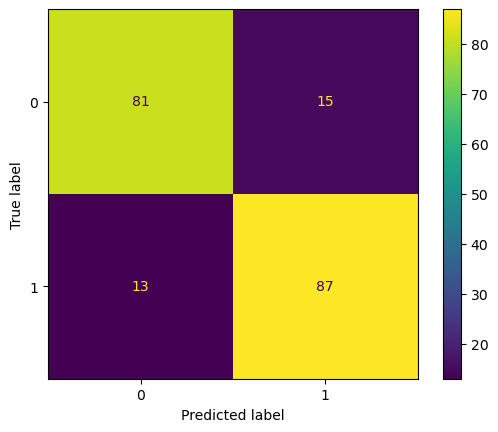

In [7]:
y_pred = []
failed_output = []

for doc in tqdm(doc_list):
    try:
        llm_output_chain = zeroshot_prompt | llm
        llm_output = llm_output_chain.invoke({"news": doc})
        json_chain = get_json | parser
        answer = json_chain.invoke(llm_output)
        assert((0 <= answer["category"] and answer["category"] <= 1))
        y_pred.append(answer["category"])
    except:
        try:
            llm_output_chain = zeroshot_failed_prompt | llm
            llm_output = llm_output_chain.invoke({"news": doc, "model_output": llm_output})
            json_chain = get_json | parser
            answer = json_chain.invoke(llm_output)
            assert((0 <= answer["category"] and answer["category"] <= 1))
            y_pred.append(answer["category"])
        except:
            y_pred.append(-1)
            failed_output.append(llm_output)

            
print("Number of invalid classifications:", y_pred.count(-1))
print("Failed Outputs:", failed_output, sep='\n')

print(classification_report(y_true, y_pred, zero_division=0.0))
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
confusion_mat.plot()
plt.show()